In [3]:
##predict icebergs vs ships by using a siamese network analyzing satellite images

from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [218]:
npz = np.load('./data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print (str(Y_train.shape[0]-1000) + " samples") 

3113 samples


In [9]:
# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

# same network architecture for both left and right
convnet = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# L1 distance of left and right encoded
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add distance to network
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.001, decay=2.5e-4)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [10]:
#refromatting training data
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: 
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:
            targets.append(1.)
        else:
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

In [11]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 18)           0           sequential_1[1][0]               
          

In [12]:
siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=30,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

Train on 5000 samples, validate on 3113 samples
Epoch 1/30
5000/5000 [==============================] - 20s 4ms/step - loss: 0.6859 - acc: 0.5464 - val_loss: 0.6910 - val_acc: 0.5445
Epoch 2/30
5000/5000 [==============================] - 20s 4ms/step - loss: 0.6308 - acc: 0.6604 - val_loss: 0.6922 - val_acc: 0.5702
Epoch 3/30
5000/5000 [==============================] - 18s 4ms/step - loss: 0.5512 - acc: 0.7356 - val_loss: 0.6948 - val_acc: 0.5577
Epoch 4/30
5000/5000 [==============================] - 19s 4ms/step - loss: 0.4947 - acc: 0.7808 - val_loss: 0.4948 - val_acc: 0.7877
Epoch 5/30
5000/5000 [==============================] - 18s 4ms/step - loss: 0.4568 - acc: 0.8046 - val_loss: 0.5914 - val_acc: 0.7167
Epoch 6/30
5000/5000 [==============================] - 18s 4ms/step - loss: 0.4274 - acc: 0.8236 - val_loss: 0.4947 - val_acc: 0.8095
Epoch 7/30
5000/5000 [==============================] - 17s 3ms/step - loss: 0.4050 - acc: 0.8302 - val_loss: 0.4668 - val_acc: 0.8108
Epoch 8

In [193]:
predictions = siamese_net.predict([test_left, test_right])

In [194]:
predictions

array([[0.998412  ],
       [0.04992351],
       [0.99858814],
       ...,
       [0.00329501],
       [0.9985507 ],
       [0.01917422]], dtype=float32)

In [200]:
def predict(num):
    i#mshow(np.squeeze(right_input[num,:,:,2]))#Looking at the combined channel
    imshow(np.squeeze(test_left[num,:,:,2]))
    plt.show()
    labels = ['Ship','Iceberg']  #0 : ship; 1: iceberg 
    print ('This is:',labels[int(test_targets[num])])
    print('Siamese network predicts: ' + labels[round(float(predictions[num]))])

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


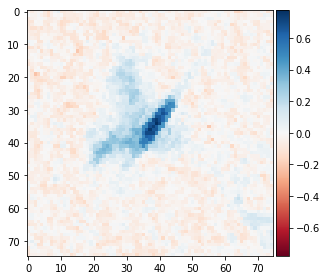

This is: Ship
Siamese network predicts: Ship


In [215]:
predict(67)